In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

In [2]:
#Setting gpu for limit memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #Restrict Tensorflow to only allocate 6gb of memory on the first GPU
   try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=9144)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
       #virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
captioning_model_path = "./models/25_4_2024_0h8"

encoder = tf.keras.models.load_model(f"{captioning_model_path}/encoder.tf") #CHANGEZ ICI

units = 512 # Taille de la couche caché dans le RNN
decoder = tf.keras.models.load_model(f"{captioning_model_path}/decoder.tf") #CHANGEZ ICI

def reset_state(batch_size):
        return tf.zeros((batch_size, units))

# tokenizer loading
with open(f'{captioning_model_path}/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [4]:
decoder.summary()

Model: "rnn__decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1280256   
                                                                 
 gru (GRU)                   multiple                  1575936   
                                                                 
 dense_1 (Dense)             multiple                  262656    
                                                                 
 dense_2 (Dense)             multiple                  2565513   
                                                                 
 bahdanau_attention (Bahdana  multiple                 394753    
 uAttention)                                                     
                                                                 
Total params: 6,079,114
Trainable params: 6,079,114
Non-trainable params: 0
____________________________________________

In [5]:
max_length = 33
attention_features_shape = 64

#inceptionV3---------
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model =  tf.keras.Model(new_input, hidden_layer)
#--------------------

# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path



def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Reshape predictions to be a 2D matrix of shape [batch_size, vocab_size]
        predictions = tf.reshape(predictions, [1, -1])

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

C:/Users/erwan/Desktop/test_data\IMG_20240424_110126.jpg
Prediction Caption: a kitchen counter and chairs are boats lined up <end>


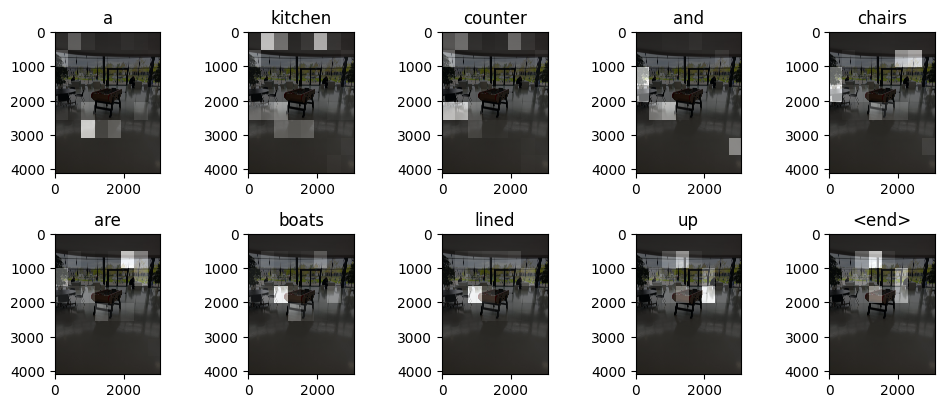

In [27]:
# Affichage de quelques annotations dans le jeu de test
images_folder = "C:/Users/erwan/Desktop/test_data"
fichiers = os.listdir(images_folder)

images = [fichier for fichier in fichiers if fichier.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

pick = os.path.join(images_folder, random.choice(images))

print(pick)
#real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(pick)

#print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(pick, result, attention_plot)